In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [3]:
import pandas as pd
import numpy as np

# CE Data
ce_path = "C:/1. Power grid frequency data/CE/2024.csv"
data_ce = pd.read_csv(ce_path, header=None, names=['Time', 'freq'])

# Convert Time column to datetime and set as index
data_ce['Time'] = pd.to_datetime(data_ce['Time'])
data_ce.set_index('Time', inplace=True)
data_ce['freq'] = pd.to_numeric(data_ce['freq'])

# Print rows with NA in CE before filtering
print("Rows with NA in CE data before filtering:")
print(data_ce[data_ce.isna().any(axis=1)])

# South Korea Data
data_sk = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")
data_sk.index = pd.to_datetime(data_sk.index)

# Print rows with NA in South Korea before filtering
print("\nRows with NA in South Korea data before filtering:")
print(data_sk[data_sk.isna().any(axis=1)])

# CE Filtering
data_filtered_ce = data_ce.dropna(subset=['freq'])
valid_hours_ce = data_filtered_ce.groupby(data_filtered_ce.index.floor('H')).filter(lambda x: len(x) == 3600)
valid_hours_ce['omega'] = 2 * np.pi * (valid_hours_ce['freq'] - 50)  # 50 Hz base for CE

# South Korea Filtering
data_filtered_sk = data_sk[(data_sk['QI'] == 0) & (data_sk['freq'].notna())].dropna()
valid_hours_sk = data_filtered_sk.groupby(data_filtered_sk.index.floor('H')).filter(lambda x: len(x) == 3600)
valid_hours_sk['omega'] = 2 * np.pi * (valid_hours_sk['freq'] - 60)  # 60 Hz base for South Korea

Rows with NA in CE data before filtering:
                     freq
Time                     
2024-03-31 03:27:07   NaN
2024-03-31 03:27:08   NaN
2024-03-31 03:27:09   NaN
2024-03-31 03:27:10   NaN
2024-03-31 03:27:11   NaN
...                   ...
2024-04-17 23:59:55   NaN
2024-04-17 23:59:56   NaN
2024-04-17 23:59:57   NaN
2024-04-17 23:59:58   NaN
2024-04-17 23:59:59   NaN

[86507 rows x 1 columns]

Rows with NA in South Korea data before filtering:
                     freq QI
2024-08-15 00:07:32   NaN  2
2024-08-15 00:07:33   NaN  2
2024-08-15 00:07:34   NaN  2
2024-08-15 00:07:35   NaN  2
2024-08-15 00:07:36   NaN  2
...                   ... ..
2024-12-09 19:19:53   NaN  2
2024-12-09 19:19:54   NaN  2
2024-12-09 20:44:42   NaN  2
2024-12-09 20:44:43   NaN  2
2024-12-09 20:44:44   NaN  2

[557296 rows x 2 columns]


C:\Users\wp7528\AppData\Local\Temp\ipykernel_9992\780342570.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  valid_hours_ce = data_filtered_ce.groupby(data_filtered_ce.index.floor('H')).filter(lambda x: len(x) == 3600)
C:\Users\wp7528\AppData\Local\Temp\ipykernel_9992\780342570.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  valid_hours_sk = data_filtered_sk.groupby(data_filtered_sk.index.floor('H')).filter(lambda x: len(x) == 3600)


In [4]:
print(len(valid_hours_ce)/3600)
print(len(valid_hours_sk)/3600)


2734.0
2451.0


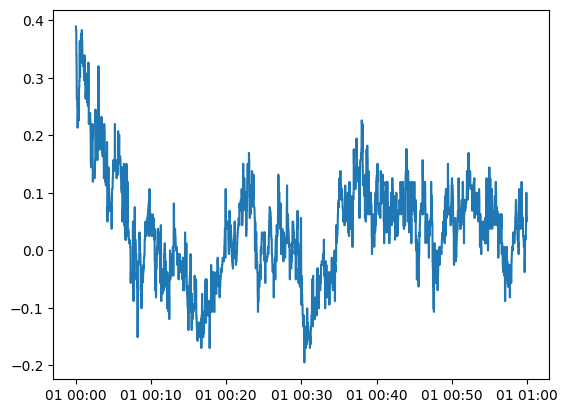

In [21]:
# Plot the omega data (ONE DAY)
plt.plot(valid_hours_ce['omega'][0:3600])

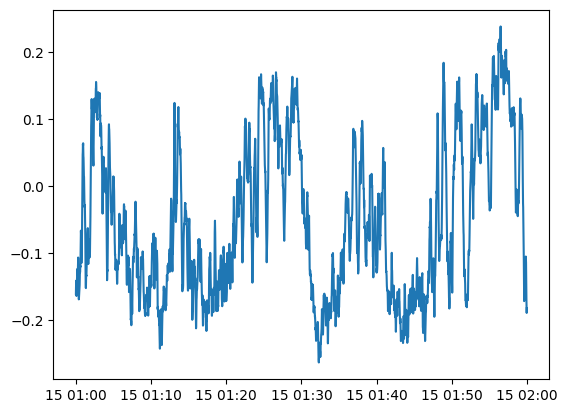

In [22]:
plt.plot(valid_hours_sk['omega'][0:3600])

In [4]:
def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data


In [5]:
from scipy.integrate import cumtrapz

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

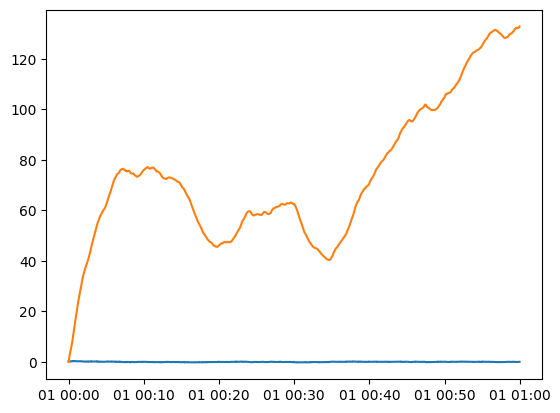

In [6]:
# Integrate the omega data and call it theta and add 'theta' column
valid_hours_ce['theta'] = integrate_data(valid_hours_ce['omega'],1)
# Plot the omega and theta data (ONE DAY)
plt.plot(valid_hours_ce['omega'][0:3600])
plt.plot(valid_hours_ce['theta'][0:3600])

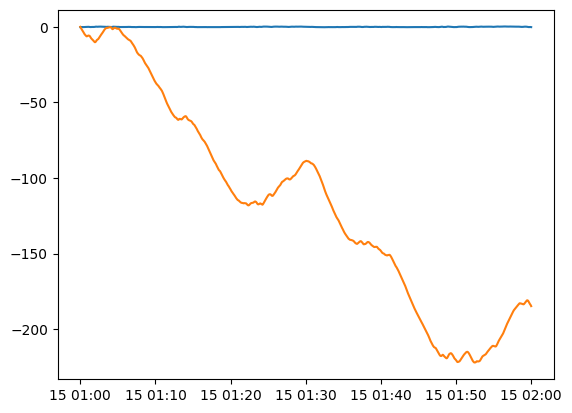

In [24]:
# Integrate the omega data and call it theta and add 'theta' column
valid_hours_sk['theta'] = integrate_data(valid_hours_sk['omega'],1)
# Plot the omega and theta data (ONE DAY)
plt.plot(valid_hours_sk['omega'][0:3600])
plt.plot(valid_hours_sk['theta'][0:3600])

In [7]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, region_name, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with the specified region name
        chunk['Region'] = region_name
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with the specified region name
        remaining_chunk['Region'] = region_name
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [8]:
# Apply Gaussian filter to the omega data
filtered_data = apply_gaussian_filter(valid_hours_ce['omega'], 'CE')

# Check the number of chunks created
print(f"Number of chunks created: {len(filtered_data)}")
filtered_data

Number of chunks created: 2734


[                        omega  omega_filtered Region
 Time                                                
 2024-01-01 00:00:00  0.389557        0.295797     CE
 2024-01-01 00:00:01  0.383274        0.295786     CE
 2024-01-01 00:00:02  0.383274        0.295765     CE
 2024-01-01 00:00:03  0.383274        0.295733     CE
 2024-01-01 00:00:04  0.339292        0.295691     CE
 ...                       ...             ...    ...
 2024-01-01 00:59:55  0.100531        0.035397     CE
 2024-01-01 00:59:56  0.100531        0.035416     CE
 2024-01-01 00:59:57  0.050265        0.035430     CE
 2024-01-01 00:59:58  0.050265        0.035439     CE
 2024-01-01 00:59:59  0.056549        0.035444     CE
 
 [3600 rows x 3 columns],
                         omega  omega_filtered Region
 Time                                                
 2024-01-01 01:00:00  0.056549       -0.180311     CE
 2024-01-01 01:00:01  0.056549       -0.180317     CE
 2024-01-01 01:00:02  0.031416       -0.180329     CE


In [9]:
from sklearn.metrics import explained_variance_score, max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = {}
    scores = {}

    transformations = {
        "linear_time": lambda chunk: np.arange(0, len(chunk), 1).reshape(-1, 1),
        "exp_1000": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
        #"exp_3600": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 3600) - 1).reshape(-1, 1),

        # Sine transformation of time
        #"sin_time": lambda chunk: np.sin((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
        
        # Cosine transformation of time
        #"cos_time": lambda chunk: np.cos((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = []

        for chunk in region_data:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            
            # Apply the selected time transformation
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
            
            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)
            
            # Compute the explained variance score
            score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name].append(score)

        # Compute the mean score for this transformation
        mean_score = np.mean(scores[transform_name])
        print(f"Mean Model Score for {region_name} using {transform_name}: {mean_score}")

    return sindy_models, scores


In [10]:
# Calculate the sindy models and scores with different n values

sindy_models_ce_n1, scores_ce_n1 = calculate_model_scores(filtered_data, 'CE', n=1)
sindy_models_ce_n2, scores_ce_n2 = calculate_model_scores(filtered_data, 'CE', n=2)
sindy_models_ce_n3, scores_ce_n3 = calculate_model_scores(filtered_data, 'CE', n=3)

Mean Model Score for CE using linear_time: 0.4073310896936006
Mean Model Score for CE using exp_1000: 0.7376621019372002
Mean Model Score for CE using linear_time: 0.5084227867594462
Mean Model Score for CE using exp_1000: 0.8332738329290742
Mean Model Score for CE using linear_time: 0.5698550255936702
Mean Model Score for CE using exp_1000: 0.9135055922410019


In [26]:
len(sindy_models_ce_n2['linear_time'])

2734

In [27]:
# Apply Gaussian filter to South Korea data
filtered_data_sk = apply_gaussian_filter(valid_hours_sk['omega'], 'South Korea')

# Check the number of chunks
print(f"Number of chunks created for South Korea: {len(filtered_data_sk)}")

# Calculate SINDy models and scores for South Korea with different polynomial degrees
sindy_models_sk_n1, scores_sk_n1 = calculate_model_scores(filtered_data_sk, 'South Korea', n=1)
sindy_models_sk_n2, scores_sk_n2 = calculate_model_scores(filtered_data_sk, 'South Korea', n=2)
sindy_models_sk_n3, scores_sk_n3 = calculate_model_scores(filtered_data_sk, 'South Korea', n=3)


Number of chunks created for South Korea: 2451
Mean Model Score for South Korea using linear_time: 0.4048262846718111
Mean Model Score for South Korea using exp_1000: 0.7178612527512411
Mean Model Score for South Korea using linear_time: 0.48315214251885213
Mean Model Score for South Korea using exp_1000: 0.8162918064759801
Mean Model Score for South Korea using linear_time: 0.5526602393660828
Mean Model Score for South Korea using exp_1000: 0.9014818954573988

SINDy Model Equations for South Korea (n=2, first chunk, linear_time):
(theta)' = 1.000 omega
(omega)' = 0.001 1 + 0.003 omega + 0.008 omega^2
(time)' = 1.000 1


In [34]:
# Optional: Print model equations for the first chunk of n=2 as an example
print("\nSINDy Model Equations for South Korea (n=2, first chunk, linear_time):")
sindy_models_sk_n2['linear_time'][6].coefficients()


SINDy Model Equations for South Korea (n=2, first chunk, linear_time):


array([[ 4.69514476e-06,  2.11644248e-07,  1.00001244e+00,
        -6.94473515e-09, -7.44186076e-09, -1.29944051e-06,
         6.01670973e-11, -2.91928484e-04, -4.08090100e-09,
         1.40193041e-12],
       [ 6.00860753e-04, -4.96179036e-05, -3.60970382e-03,
         4.55003020e-08,  5.83494488e-07,  6.44178763e-05,
         1.18225947e-10,  6.93160154e-03,  1.17845801e-06,
         0.00000000e+00],
       [ 1.00000000e+00,  1.98803611e-16, -5.19014220e-14,
        -9.17714314e-18, -2.56231277e-18,  2.39945934e-15,
        -1.79712589e-19,  1.96904637e-13, -2.87925559e-16,
         7.13708200e-21]])

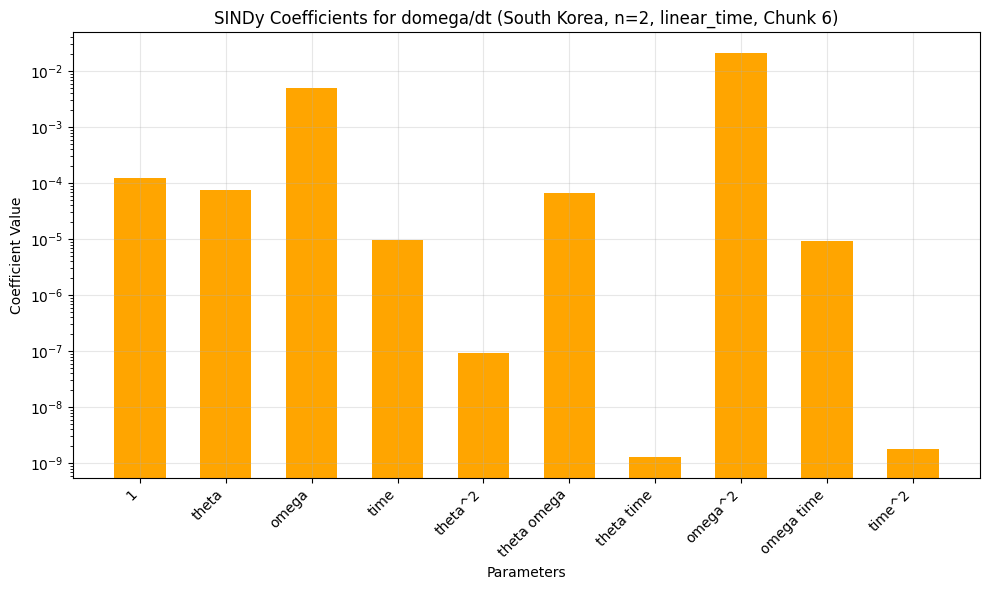

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Select the specific model (South Korea, n=2, linear_time, chunk 6)
model = sindy_models_sk_n2['linear_time'][60]

# Get coefficients and feature names
coefficients = model.coefficients()  # Shape: (n_outputs, n_features)
feature_names = model.get_feature_names()

# Extract coefficients for domega/dt (second row, index 1)
domega_dt_coefficients = np.abs(coefficients[1])  # Only the coefficients for domega/dt

# Plotting
plt.figure(figsize=(10, 6))

# Bar positions
x = np.arange(len(feature_names))

# Plot coefficients for domega/dt
plt.bar(x, domega_dt_coefficients, color='orange', width=0.6)

# Customize plot
plt.xlabel('Parameters')
plt.ylabel('Coefficient Value')
plt.title('SINDy Coefficients for domega/dt (South Korea, n=2, linear_time, Chunk 6)')
plt.xticks(x, feature_names, rotation=45, ha='right')  # Feature names on x-axis
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()

# Show plot
plt.show()

In [38]:
feature_names

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2']

In [11]:
filtered_data_sk = apply_gaussian_filter(valid_hours_sk['omega'], 'South Korea')

Original Model Coefficients for domega/dt:
1: 0.0006008607533958101
theta: -4.961790356865882e-05
omega: -0.003609703818215285
time: 4.550030202456381e-08
theta^2: 5.834944875776121e-07
theta omega: 6.441787634965055e-05
theta time: 1.1822594668525884e-10
omega^2: 0.006931601541861104
omega time: 1.1784580120378348e-06
time^2: 0.0
Original Model Score: 0.4615275584156296

Modified Model Coefficients for domega/dt (time = 0):
1: 0.0006008607533958101
theta: -4.961790356865882e-05
omega: -0.003609703818215285
time: 0.0
theta^2: 5.834944875776121e-07
theta omega: 6.441787634965055e-05
theta time: 1.1822594668525884e-10
omega^2: 0.006931601541861104
omega time: 1.1784580120378348e-06
time^2: 0.0
Modified Model Score: 0.12796684533141156


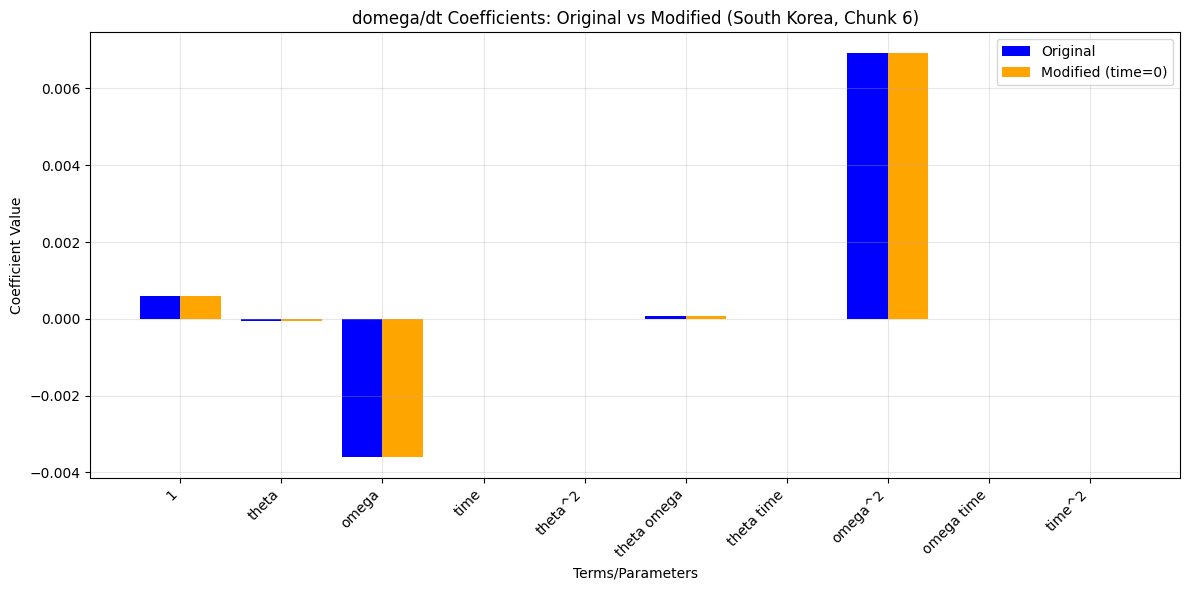

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from pysindy import SINDy
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary
from sklearn.metrics import explained_variance_score
from scipy.integrate import solve_ivp

# Extract the original data for chunk 6 (South Korea, n=2, linear_time)
chunk = filtered_data_sk[6]
theta_chunk = integrate_data(chunk['omega_filtered'].values)
stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
t_train_chunk = np.arange(0, len(chunk), 1).reshape(-1, 1)  # linear_time transformation
x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])

# Feature names
feature_names = ['1', 'theta', 'omega', 'time', 'theta^2', 'theta omega', 
                 'theta time', 'omega^2', 'omega time', 'time^2']
n_features = len(feature_names)

# Fit original model
poly_library = PolynomialLibrary(degree=2)
optimizer = STLSQ(threshold=1e-10)
model = SINDy(feature_names=feature_names, 
              feature_library=poly_library, 
              optimizer=optimizer)
model.fit(x_train_augmented_chunk, t=1)

# Original coefficients and score
original_coefficients = model.coefficients()
original_score = model.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)

# Modify coefficients: set "time" (index 3) to 0 for domega/dt (second row)
modified_coefficients = original_coefficients.copy()
modified_coefficients[1, 3] = 0  # Index 3 is "time" for domega/dt

# Define the modified system dynamics manually
def modified_dynamics(t, x, coeffs, library):
    # x = [theta, omega], t is time
    features = library.fit_transform(np.column_stack((x[0], x[1], t)))
    dtheta_dt = coeffs[0] @ features.T  # First row for dtheta/dt
    domega_dt = coeffs[1] @ features.T  # Second row for domega/dt
    return [dtheta_dt[0], domega_dt[0]]

# Simulate the modified system
t_span = np.arange(0, len(chunk), 1)
x0 = x_train_augmented_chunk[0, :2]  # Initial conditions [theta0, omega0]
sol = solve_ivp(
    lambda t, x: modified_dynamics(t, x, modified_coefficients, poly_library),
    [t_span[0], t_span[-1]],
    x0,
    t_eval=t_span,
    method='LSODA',
    rtol=1e-12,
    atol=1e-12
)

# Compute modified score
simulated_data = sol.y.T  # [theta, omega]
true_data = stacked_data_chunk  # [theta, omega] from original data
modified_score = explained_variance_score(true_data, simulated_data)

# Print results
print("Original Model Coefficients for domega/dt:")
for name, coef in zip(feature_names, original_coefficients[1]):
    print(f"{name}: {coef}")
print(f"Original Model Score: {original_score}")

print("\nModified Model Coefficients for domega/dt (time = 0):")
for name, coef in zip(feature_names, modified_coefficients[1]):
    print(f"{name}: {coef}")
print(f"Modified Model Score: {modified_score}")

# Plot coefficients for comparison
plt.figure(figsize=(12, 6))
x = np.arange(n_features)
plt.bar(x - 0.2, original_coefficients[1], 0.4, label='Original', color='blue')
plt.bar(x + 0.2, modified_coefficients[1], 0.4, label='Modified (time=0)', color='orange')
plt.xticks(x, feature_names, rotation=45, ha='right')
plt.xlabel('Terms/Parameters')
plt.ylabel('Coefficient Value')
plt.title('domega/dt Coefficients: Original vs Modified (South Korea, Chunk 6)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Pyt


Mean Original RMSE across all chunks (sigma=60): 0.12327401735289273
Mean Constrained RMSE across all chunks (sigma=60): 0.12135041031316371

Total chunks processed: 2451
Number of unstable original chunks: 1483
Share of unstable original chunks: 60.51%
Number of unstable constrained chunks: 1435
Share of unstable constrained chunks: 58.55%


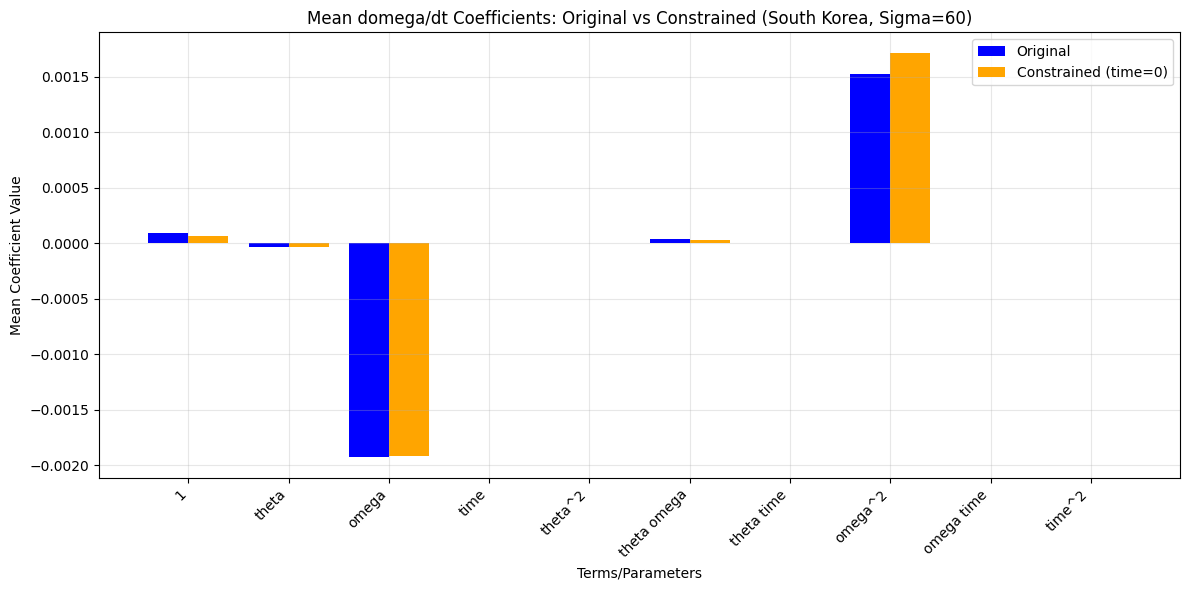

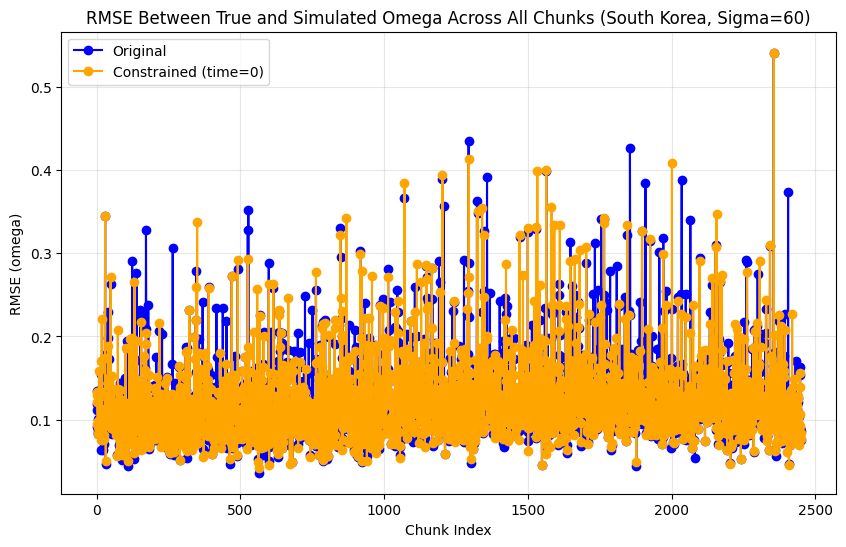

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pysindy import SINDy
from pysindy.optimizers import STLSQ, ConstrainedSR3
from pysindy.feature_library import PolynomialLibrary
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific ConvergenceWarning from ConstrainedSR3
warnings.filterwarnings("ignore", category=ConvergenceWarning, 
                        module="pysindy.optimizers.constrained_sr3")

# Functions from your code
def apply_gaussian_filter(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Feature names
feature_names = ['1', 'theta', 'omega', 'time', 'theta^2', 'theta omega', 
                 'theta time', 'omega^2', 'omega time', 'time^2']
n_features = len(feature_names)

# Simulation parameters
s = 1  # Sampling rate (1 Hz)
delta_t = 1 / s
simulation_steps = 3600
divergence_threshold = 0.2

# Single sigma value
sigma = 60

# Initialize lists to store results
original_rmse = []
constrained_rmse = []
original_coeffs_all = []
constrained_coeffs_all = []
unstable_original = 0  # Counter for unstable original chunks
unstable_constrained = 0  # Counter for unstable constrained chunks
total_chunks = 0  # Total number of chunks processed

# Polynomial library
poly_library = PolynomialLibrary(degree=2)

# Optimizers
original_optimizer = STLSQ(threshold=1e-10)
constraint_lhs = np.zeros((1, 3 * n_features))  # 3 outputs: dtheta/dt, domega/dt, dtime/dt
constraint_lhs[0, n_features + 3] = 1  # "time" term in domega/dt (second row, index 3)
constraint_rhs = np.array([0])
constrained_optimizer = ConstrainedSR3(
    threshold=1e-10,
    constraint_lhs=constraint_lhs,
    constraint_rhs=constraint_rhs,
    constraint_order="feature"
)

# Suppress numerical warnings
np.seterr(over='raise', divide='raise', invalid='raise')

# Loop over all chunks in filtered_data_sk
for i, chunk in enumerate(filtered_data_sk):
    total_chunks += 1

    # Apply Gaussian filter with sigma=60
    omega_filtered = apply_gaussian_filter(chunk['omega'].values, sigma=sigma)
    chunk['omega_filtered'] = omega_filtered

    # Prepare data for SINDy
    theta_chunk = integrate_data(chunk['omega_filtered'].values)
    stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
    t_train_chunk = np.arange(0, len(chunk), 1).reshape(-1, 1)
    x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])  # [theta, omega, time]

    # True omega for comparison
    true_omega = chunk['omega'].values

    # Time points
    time_points = np.arange(0, simulation_steps, 1) * delta_t

    # Fit original model (STLSQ) for 3 states
    original_model = SINDy(feature_names=feature_names, 
                           feature_library=poly_library, 
                           optimizer=original_optimizer)
    original_model.fit(x_train_augmented_chunk, t=1)
    original_coefficients = original_model.coefficients()

    # Manual simulation for original model
    th = np.zeros(simulation_steps)
    om = np.zeros(simulation_steps)
    t = np.zeros(simulation_steps)
    th[0], om[0], t[0] = theta_chunk[0], true_omega[0], 0
    limited_simulation = False

    try:
        for step in range(simulation_steps - 1):
            state = np.array([th[step], om[step], t[step]])
            features = poly_library.fit_transform(state.reshape(1, -1))[0]
            derivatives = original_coefficients @ features

            th[step + 1] = th[step] + delta_t * derivatives[0]
            om[step + 1] = om[step] + delta_t * derivatives[1]
            t[step + 1] = t[step] + delta_t * derivatives[2]

            if np.abs(om[step + 1]) > divergence_threshold:
                limited_simulation = True
                simulation_end = step + 2
                unstable_original += 1
                break
    except (FloatingPointError, OverflowError, RuntimeWarning):
        limited_simulation = True
        simulation_end = 3600
        unstable_original += 1

    om_used = om[:simulation_end] if limited_simulation else om
    true_omega_used = true_omega[:len(om_used)]
    rmse_original = calculate_rmse(true_omega_used, om_used)
    original_rmse.append(rmse_original)
    original_coeffs_all.append(original_coefficients[1])

    # Fit constrained model
    constrained_model = SINDy(feature_names=feature_names, 
                              feature_library=poly_library, 
                              optimizer=constrained_optimizer)
    constrained_model.fit(x_train_augmented_chunk, t=1)
    constrained_coefficients = constrained_model.coefficients()

    # Manual simulation for constrained model
    th = np.zeros(simulation_steps)
    om = np.zeros(simulation_steps)
    t = np.zeros(simulation_steps)
    th[0], om[0], t[0] = 0, 0, 0
    limited_simulation = False

    try:
        for step in range(simulation_steps - 1):
            state = np.array([th[step], om[step], t[step]])
            features = poly_library.fit_transform(state.reshape(1, -1))[0]
            derivatives = constrained_coefficients @ features

            th[step + 1] = th[step] + delta_t * derivatives[0]
            om[step + 1] = om[step] + delta_t * derivatives[1]
            t[step + 1] = t[step] + delta_t * derivatives[2]

            if np.abs(om[step + 1]) > divergence_threshold:
                limited_simulation = True
                simulation_end = step + 2
                unstable_constrained += 1
                break
    except (FloatingPointError, OverflowError, RuntimeWarning):
        limited_simulation = True
        simulation_end = 3600
        unstable_constrained += 1

    om_used = om[:simulation_end] if limited_simulation else om
    true_omega_used = true_omega[:len(om_used)]
    rmse_constrained = calculate_rmse(true_omega_used, om_used)
    constrained_rmse.append(rmse_constrained)
    constrained_coeffs_all.append(constrained_coefficients[1])

# Aggregate results
mean_original_rmse = np.mean(original_rmse)
mean_constrained_rmse = np.mean(constrained_rmse)
print(f"\nMean Original RMSE across all chunks (sigma=60): {mean_original_rmse}")
print(f"Mean Constrained RMSE across all chunks (sigma=60): {mean_constrained_rmse}")

# Calculate and print unstable chunk statistics
print(f"\nTotal chunks processed: {total_chunks}")
print(f"Number of unstable original chunks: {unstable_original}")
print(f"Share of unstable original chunks: {unstable_original / total_chunks:.2%}")
print(f"Number of unstable constrained chunks: {unstable_constrained}")
print(f"Share of unstable constrained chunks: {unstable_constrained / total_chunks:.2%}")

# Plot mean coefficients across all chunks
mean_original_coeffs = np.mean(original_coeffs_all, axis=0)
mean_constrained_coeffs = np.mean(constrained_coeffs_all, axis=0)

plt.figure(figsize=(12, 6))
x = np.arange(n_features)
plt.bar(x - 0.2, mean_original_coeffs, 0.4, label='Original', color='blue')
plt.bar(x + 0.2, mean_constrained_coeffs, 0.4, label='Constrained (time=0)', color='orange')
plt.xticks(x, feature_names, rotation=45, ha='right')
plt.xlabel('Terms/Parameters')
plt.ylabel('Mean Coefficient Value')
plt.title('Mean domega/dt Coefficients: Original vs Constrained (South Korea, Sigma=60)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot RMSE for all chunks
plt.figure(figsize=(10, 6))
plt.plot(original_rmse, label='Original', color='blue', marker='o')
plt.plot(constrained_rmse, label='Constrained (time=0)', color='orange', marker='o')
plt.xlabel('Chunk Index')
plt.ylabel('RMSE (omega)')
plt.title('RMSE Between True and Simulated Omega Across All Chunks (South Korea, Sigma=60)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Pyt


Mean Original RMSE across all chunks (sigma=60): 0.13780099362477552
Mean Constrained RMSE across all chunks (sigma=60): 0.11972187889094045

Total chunks processed: 2451
Number of unstable original chunks: 1109
Share of unstable original chunks: 45.25%
Number of unstable constrained chunks: 806
Share of unstable constrained chunks: 32.88%


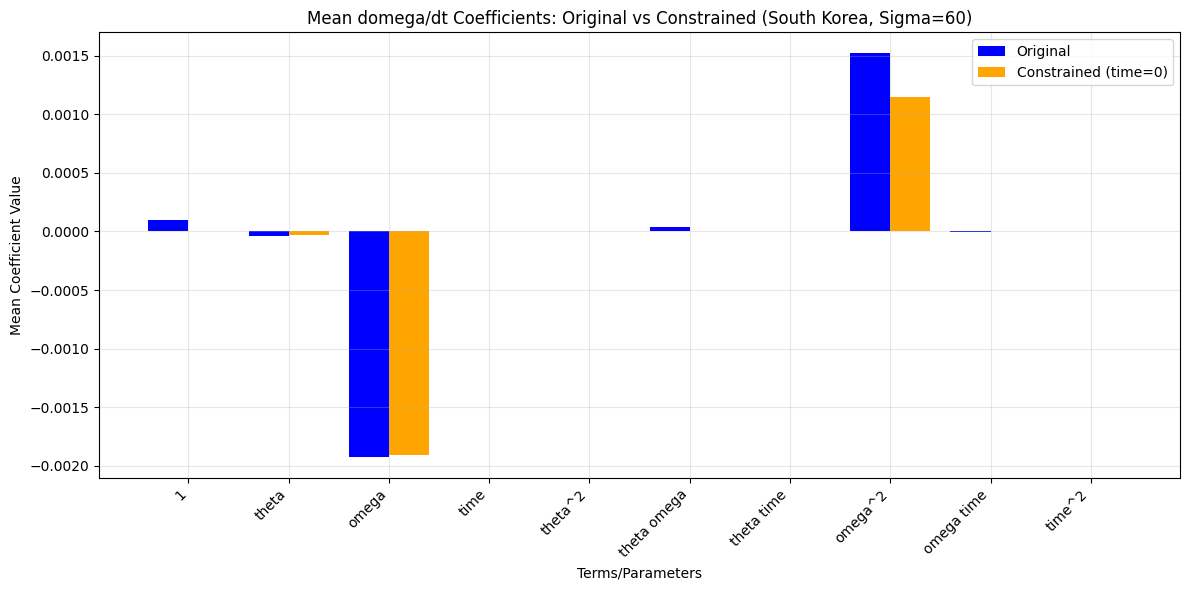

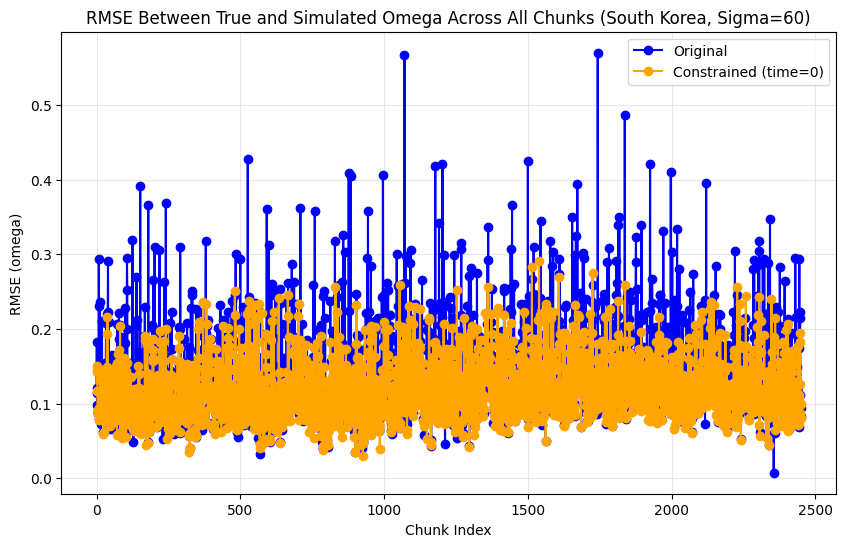

In [36]:

warnings.filterwarnings("ignore")

# Functions from your code
def apply_gaussian_filter(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Feature names
feature_names = ['1', 'theta', 'omega', 'time', 'theta^2', 'theta omega', 
                 'theta time', 'omega^2', 'omega time', 'time^2']
n_features = len(feature_names)

# Simulation parameters
s = 1  # Sampling rate (1 Hz)
delta_t = 1 / s
simulation_steps = 3600
divergence_threshold = 0.5

# Single sigma value
sigma = 60

# Initialize lists to store results
original_rmse = []
constrained_rmse = []
original_coeffs_all = []
constrained_coeffs_all = []
unstable_original = 0  # Counter for unstable original chunks
unstable_constrained = 0  # Counter for unstable constrained chunks
total_chunks = 0  # Total number of chunks processed

# Polynomial library
poly_library = PolynomialLibrary(degree=2)

# Optimizers
original_optimizer = STLSQ(threshold=1e-10)
constraint_lhs = np.zeros((1, 3 * n_features))  # 3 outputs: dtheta/dt, domega/dt, dtime/dt
constraint_lhs[0, n_features + 6] = 1  # "time" term in domega/dt (second row, index 3)
constraint_rhs = np.array([0])
constrained_optimizer = ConstrainedSR3(
    threshold=1e-10,
    constraint_lhs=constraint_lhs,
    constraint_rhs=constraint_rhs,
    constraint_order="feature"
)

# Suppress numerical warnings
np.seterr(over='raise', divide='raise', invalid='raise')

# Loop over all chunks in filtered_data_sk
for i, chunk in enumerate(filtered_data_sk):
    total_chunks += 1

    # Apply Gaussian filter with sigma=60
    omega_filtered = apply_gaussian_filter(chunk['omega'].values, sigma=sigma)
    chunk['omega_filtered'] = omega_filtered

    # Prepare data for SINDy
    theta_chunk = integrate_data(chunk['omega_filtered'].values)
    stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
    t_train_chunk = np.arange(0, len(chunk), 1).reshape(-1, 1)
    x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])  # [theta, omega, time]

    # True omega for comparison
    true_omega = chunk['omega'].values

    # Time points
    time_points = np.arange(0, simulation_steps, 1) * delta_t

    # Fit original model (STLSQ) for 3 states
    original_model = SINDy(feature_names=feature_names, 
                           feature_library=poly_library, 
                           optimizer=original_optimizer)
    original_model.fit(x_train_augmented_chunk, t=1)
    original_coefficients = original_model.coefficients()

    # Manual simulation for original model
    th = np.zeros(simulation_steps)
    om = np.zeros(simulation_steps)
    t = np.zeros(simulation_steps)
    th[0], om[0], t[0] = theta_chunk[0], true_omega[0], 0
    limited_simulation = False

    try:
        for step in range(simulation_steps - 1):
            state = np.array([th[step], om[step], t[step]])
            features = poly_library.fit_transform(state.reshape(1, -1))[0]
            derivatives = original_coefficients @ features

            th[step + 1] = th[step] + delta_t * derivatives[0]
            om[step + 1] = om[step] + delta_t * derivatives[1]
            t[step + 1] = t[step] + delta_t * derivatives[2]

            if np.abs(om[step + 1]) > divergence_threshold:
                limited_simulation = True
                simulation_end = step + 2
                unstable_original += 1
                break
    except (FloatingPointError, OverflowError, RuntimeWarning):
        limited_simulation = True
        simulation_end = 3600
        unstable_original += 1

    om_used = om[:simulation_end] if limited_simulation else om
    true_omega_used = true_omega[:len(om_used)]
    rmse_original = calculate_rmse(true_omega_used, om_used)
    original_rmse.append(rmse_original)
    original_coeffs_all.append(original_coefficients[1])

    # Fit constrained model
    constrained_model = SINDy(feature_names=feature_names, 
                              feature_library=poly_library, 
                              optimizer=constrained_optimizer)
    constrained_model.fit(x_train_augmented_chunk, t=1)
    constrained_coefficients = constrained_model.coefficients()

    # Manual simulation for constrained model
    th = np.zeros(simulation_steps)
    om = np.zeros(simulation_steps)
    t = np.zeros(simulation_steps)
    th[0], om[0], t[0] = theta_chunk[0], omega_filtered[0], 0
    limited_simulation = False

    try:
        for step in range(simulation_steps - 1):
            state = np.array([th[step], om[step], t[step]])
            features = poly_library.fit_transform(state.reshape(1, -1))[0]
            derivatives = constrained_coefficients @ features

            th[step + 1] = th[step] + delta_t * derivatives[0]
            om[step + 1] = om[step] + delta_t * derivatives[1]
            t[step + 1] = t[step] + delta_t * derivatives[2]

            if np.abs(om[step + 1]) > divergence_threshold:
                limited_simulation = True
                simulation_end = step + 2
                unstable_constrained += 1
                break
    except (FloatingPointError, OverflowError, RuntimeWarning):
        limited_simulation = True
        simulation_end = 3600
        unstable_constrained += 1

    om_used = om[:simulation_end] if limited_simulation else om
    true_omega_used = true_omega[:len(om_used)]
    rmse_constrained = calculate_rmse(true_omega_used, om_used)
    constrained_rmse.append(rmse_constrained)
    constrained_coeffs_all.append(constrained_coefficients[1])

# Aggregate results
mean_original_rmse = np.mean(original_rmse)
mean_constrained_rmse = np.mean(constrained_rmse)
print(f"\nMean Original RMSE across all chunks (sigma=60): {mean_original_rmse}")
print(f"Mean Constrained RMSE across all chunks (sigma=60): {mean_constrained_rmse}")

# Calculate and print unstable chunk statistics
print(f"\nTotal chunks processed: {total_chunks}")
print(f"Number of unstable original chunks: {unstable_original}")
print(f"Share of unstable original chunks: {unstable_original / total_chunks:.2%}")
print(f"Number of unstable constrained chunks: {unstable_constrained}")
print(f"Share of unstable constrained chunks: {unstable_constrained / total_chunks:.2%}")

# Plot mean coefficients across all chunks
mean_original_coeffs = np.mean(original_coeffs_all, axis=0)
mean_constrained_coeffs = np.mean(constrained_coeffs_all, axis=0)

plt.figure(figsize=(12, 6))
x = np.arange(n_features)
plt.bar(x - 0.2, mean_original_coeffs, 0.4, label='Original', color='blue')
plt.bar(x + 0.2, mean_constrained_coeffs, 0.4, label='Constrained (time=0)', color='orange')
plt.xticks(x, feature_names, rotation=45, ha='right')
plt.xlabel('Terms/Parameters')
plt.ylabel('Mean Coefficient Value')
plt.title('Mean domega/dt Coefficients: Original vs Constrained (South Korea, Sigma=60)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot RMSE for all chunks
plt.figure(figsize=(10, 6))
plt.plot(original_rmse, label='Original', color='blue', marker='o')
plt.plot(constrained_rmse, label='Constrained (time=0)', color='orange', marker='o')
plt.xlabel('Chunk Index')
plt.ylabel('RMSE (omega)')
plt.title('RMSE Between True and Simulated Omega Across All Chunks (South Korea, Sigma=60)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# WRONG WRONG WRONG
                        

# Functions from your code
def apply_gaussian_filter(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Feature names
feature_names = ['1', 'theta', 'omega', 'time', 'theta^2', 'theta omega', 
                 'theta time', 'omega^2', 'omega time', 'time^2']
n_features = len(feature_names)

# Simulation parameters
s = 1  # Sampling rate (1 Hz)
delta_t = 1 / s
simulation_steps = 3600
divergence_threshold = 0.5

# Single sigma value
sigma = 60

# Polynomial library
poly_library = PolynomialLibrary(degree=2)

# Optimizers for original model (unchanged)
original_optimizer = STLSQ(threshold=1e-10)

# Store results for each constraint
results = {
    'constraint_index': [],
    'constrained_term': [],
    'mean_original_rmse': [],
    'mean_constrained_rmse': [],
    'unstable_original': [],
    'unstable_constrained': [],
    'total_chunks': []
}

# Loop over constraint indices from n_features + 3 to n_features + 9
constraint_indices = range(n_features + 3, n_features + 10)  # 13 to 19
constrained_terms = feature_names[3:10]  # Corresponding terms: 'time' to 'time^2'

for constraint_idx, constrained_term in zip(constraint_indices, constrained_terms):
    # Initialize lists for this constraint case
    original_rmse = []
    constrained_rmse = []
    original_coeffs_all = []
    constrained_coeffs_all = []
    unstable_original = 0
    unstable_constrained = 0
    total_chunks = 0

    # Set up constrained optimizer for this specific term
    constraint_lhs = np.zeros((1, 3 * n_features))  # Single constraint
    constraint_lhs[0, constraint_idx] = 1  # Constrain one term in domega/dt
    constraint_rhs = np.array([0])
    constrained_optimizer = ConstrainedSR3(
        threshold=1e-10,
        constraint_lhs=constraint_lhs,
        constraint_rhs=constraint_rhs,
        constraint_order="feature"
    )

    # Suppress numerical warnings
    np.seterr(over='raise', divide='raise', invalid='raise')

    # Loop over all chunks in filtered_data_sk
    for i, chunk in enumerate(filtered_data_sk):
        total_chunks += 1

        # Apply Gaussian filter with sigma=60
        omega_filtered = apply_gaussian_filter(chunk['omega'].values, sigma=sigma)
        chunk['omega_filtered'] = omega_filtered

        # Prepare data for SINDy
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
        t_train_chunk = np.arange(0, len(chunk), 1).reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])

        # True omega for comparison
        true_omega = chunk['omega'].values

        # Time points
        time_points = np.arange(0, simulation_steps, 1) * delta_t

        # Fit original model (STLSQ) for 3 states
        original_model = SINDy(feature_names=feature_names, 
                               feature_library=poly_library, 
                               optimizer=original_optimizer)
        original_model.fit(x_train_augmented_chunk, t=1)
        original_coefficients = original_model.coefficients()

        # Manual simulation for original model
        th = np.zeros(simulation_steps)
        om = np.zeros(simulation_steps)
        t = np.zeros(simulation_steps)
        th[0], om[0], t[0] = theta_chunk[0], true_omega[0], 0 
        limited_simulation = False

        try:
            for step in range(simulation_steps - 1):
                state = np.array([th[step], om[step], t[step]])
                features = poly_library.fit_transform(state.reshape(1, -1))[0]
                derivatives = original_coefficients @ features

                th[step + 1] = th[step] + delta_t * derivatives[0]
                om[step + 1] = om[step] + delta_t * derivatives[1]
                t[step + 1] = t[step] + delta_t * derivatives[2]

                if np.abs(om[step + 1]) > divergence_threshold:
                    limited_simulation = True
                    simulation_end = step + 2
                    unstable_original += 1
                    break
        except (FloatingPointError, OverflowError, RuntimeWarning):
            limited_simulation = True
            simulation_end = 3600
            unstable_original += 1

        om_used = om[:simulation_end] if limited_simulation else om
        true_omega_used = true_omega[:len(om_used)]
        rmse_original = calculate_rmse(true_omega_used, om_used)
        original_rmse.append(rmse_original)
        original_coeffs_all.append(original_coefficients[1])

        # Fit constrained model
        constrained_model = SINDy(feature_names=feature_names, 
                                  feature_library=poly_library, 
                                  optimizer=constrained_optimizer)
        constrained_model.fit(x_train_augmented_chunk, t=1)
        constrained_coefficients = constrained_model.coefficients()

        # Manual simulation for constrained model
        th = np.zeros(simulation_steps)
        om = np.zeros(simulation_steps)
        t = np.zeros(simulation_steps)
        th[0], om[0], t[0] = theta_chunk[0], omega_filtered[0], 0
        limited_simulation = False

        try:
            for step in range(simulation_steps - 1):
                state = np.array([th[step], om[step], t[step]])
                features = poly_library.fit_transform(state.reshape(1, -1))[0]
                derivatives = constrained_coefficients @ features

                th[step + 1] = th[step] + delta_t * derivatives[0]
                om[step + 1] = om[step] + delta_t * derivatives[1]
                t[step + 1] = t[step] + delta_t * derivatives[2]

                if np.abs(om[step + 1]) > divergence_threshold:
                    limited_simulation = True
                    simulation_end = step + 2
                    unstable_constrained += 1
                    break
        except (FloatingPointError, OverflowError, RuntimeWarning):
            limited_simulation = True
            simulation_end = 3600
            unstable_constrained += 1

        om_used = om[:simulation_end] if limited_simulation else om
        true_omega_used = true_omega[:len(om_used)]
        rmse_constrained = calculate_rmse(true_omega_used, om_used)
        constrained_rmse.append(rmse_constrained)
        constrained_coeffs_all.append(constrained_coefficients[1])

    # Aggregate results for this constraint
    mean_original_rmse = np.mean(original_rmse)
    mean_constrained_rmse = np.mean(constrained_rmse)

    # Store results
    results['constraint_index'].append(constraint_idx)
    results['constrained_term'].append(constrained_term)
    results['mean_original_rmse'].append(mean_original_rmse)
    results['mean_constrained_rmse'].append(mean_constrained_rmse)
    results['unstable_original'].append(unstable_original)
    results['unstable_constrained'].append(unstable_constrained)
    results['total_chunks'].append(total_chunks)

# Print results for all constraints
print("\nResults for each constrained term in domega/dt (sigma=60):")
for i in range(len(results['constraint_index'])):
    idx = results['constraint_index'][i]
    term = results['constrained_term'][i]
    orig_rmse = results['mean_original_rmse'][i]
    const_rmse = results['mean_constrained_rmse'][i]
    unst_orig = results['unstable_original'][i]
    unst_const = results['unstable_constrained'][i]
    total = results['total_chunks'][i]
    print(f"\nConstrained term: {term} (index {idx})")
    print(f"Mean Original RMSE: {orig_rmse}")
    print(f"Mean Constrained RMSE: {const_rmse}")
    print(f"Number of unstable original chunks: {unst_orig}")
    print(f"Share of unstable original chunks: {unst_orig / total:.2%}")
    print(f"Number of unstable constrained chunks: {unst_const}")
    print(f"Share of unstable constrained chunks: {unst_const / total:.2%}")



C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Pyt

KeyboardInterrupt: 

In [30]:
# Print results for all constraints
print("\nResults for each constrained term in domega/dt (sigma=60):")
for i in range(len(results['constraint_index'])):
    idx = results['constraint_index'][i]
    term = results['constrained_term'][i]
    orig_rmse = results['mean_original_rmse'][i]
    const_rmse = results['mean_constrained_rmse'][i]
    unst_orig = results['unstable_original'][i]
    unst_const = results['unstable_constrained'][i]
    total = results['total_chunks'][i]
    print(f"\nConstrained term: {term} (index {idx})")
    print(f"Mean Original RMSE: {orig_rmse}")
    print(f"Mean Constrained RMSE: {const_rmse}")
    print(f"Number of unstable original chunks: {unst_orig}")
    print(f"Share of unstable original chunks: {unst_orig / total:.2%}")
    print(f"Number of unstable constrained chunks: {unst_const}")
    print(f"Share of unstable constrained chunks: {unst_const / total:.2%}")


Results for each constrained term in domega/dt (sigma=60):

Constrained term: time (index 13)
Mean Original RMSE: 0.13780099362477552
Mean Constrained RMSE: 0.13805921794420098
Number of unstable original chunks: 1109
Share of unstable original chunks: 45.25%
Number of unstable constrained chunks: 923
Share of unstable constrained chunks: 37.66%

Constrained term: theta^2 (index 14)
Mean Original RMSE: 0.13780099362477552
Mean Constrained RMSE: 0.14288091761387292
Number of unstable original chunks: 1109
Share of unstable original chunks: 45.25%
Number of unstable constrained chunks: 1078
Share of unstable constrained chunks: 43.98%

Constrained term: theta omega (index 15)
Mean Original RMSE: 0.13780099362477552
Mean Constrained RMSE: 0.1428751616008178
Number of unstable original chunks: 1109
Share of unstable original chunks: 45.25%
Number of unstable constrained chunks: 1078
Share of unstable constrained chunks: 43.98%

Constrained term: theta time (index 16)
Mean Original RMSE: 0

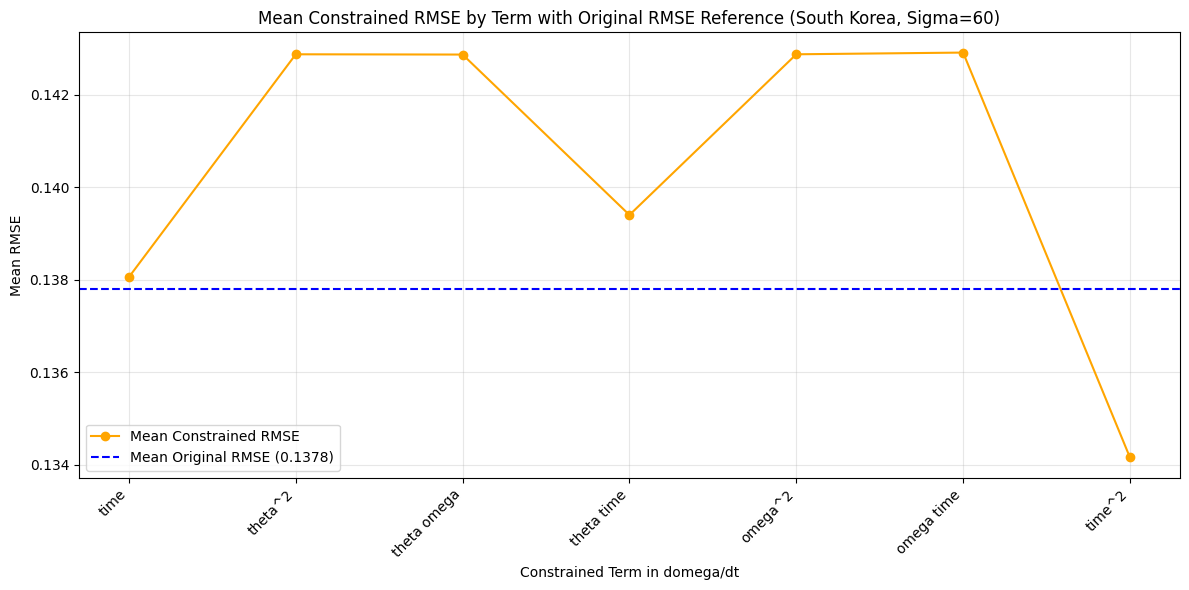

In [35]:
# Plot mean constrained RMSE with horizontal line for mean original RMSE
plt.figure(figsize=(12, 6))
x = np.arange(len(results['constrained_term']))
plt.plot(x, results['mean_constrained_rmse'], label='Mean Constrained RMSE', color='orange', marker='o')
plt.axhline(y=0.13780099362477552, color='blue', linestyle='--', label='Mean Original RMSE (0.1378)')
plt.xticks(x, results['constrained_term'], rotation=45, ha='right')
plt.xlabel('Constrained Term in domega/dt')
plt.ylabel('Mean RMSE')
#plt.yscale('log')
plt.title('Mean Constrained RMSE by Term with Original RMSE Reference (South Korea, Sigma=60)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
#sindy_models['exp_1000'][0].coefficients()
# get the mean coefficient of features
def get_mean_coefficients(sindy_models):
    mean_coefficients = {}
    for transform_name, models in sindy_models.items():
        mean_coefficients[transform_name] = np.mean([model.coefficients() for model in models], axis=0)
    return mean_coefficients



In [71]:
mean_coefficients = get_mean_coefficients(sindy_models)


feature_names = sindy_models['exp_1000'][0].get_feature_names()


for transform_name, coeff_matrix in mean_coefficients.items():
    print(f"Transform: {transform_name}")
      
    for eq_idx, coefficients in enumerate(coeff_matrix):
        print(f"  Equation {eq_idx + 1}:")
               
        for feature, coef in zip(feature_names, coefficients):
            print(f"    {feature}: {coef:.6e}") 


Transform: exp_1000
  Equation 1:
    1: 2.531413e-06
    theta: -9.259120e-08
    omega: 9.999207e-01
    time: 4.253807e-08
    theta^2: 7.148297e-10
    theta omega: 2.232606e-07
    theta time: -1.612538e-09
    omega^2: 1.617917e-04
    omega time: -5.168311e-06
    time^2: 2.354993e-08
    theta^3: 1.344602e-11
    theta^2 omega: -1.843642e-08
    theta^2 time: -5.828799e-11
    theta omega^2: 5.867185e-07
    theta omega time: 7.374280e-08
    theta time^2: 1.098082e-10
    omega^3: -9.048247e-04
    omega^2 time: 1.386052e-06
    omega time^2: -4.067124e-07
    time^3: -3.104675e-10
  Equation 2:
    1: -2.864220e-05
    theta: -5.113040e-05
    omega: -1.676107e-03
    time: 9.791005e-04
    theta^2: 1.031473e-07
    theta omega: 3.221363e-05
    theta time: -1.854835e-05
    omega^2: -1.999876e-03
    omega time: -6.111457e-04
    time^2: 3.812156e-05
    theta^3: -2.569559e-08
    theta^2 omega: -1.858267e-07
    theta^2 time: 7.766383e-08
    theta omega^2: -5.551334e-04
  

In [78]:
feature_names_list = list(feature_names)

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2',
 'theta^3',
 'theta^2 omega',
 'theta^2 time',
 'theta omega^2',
 'theta omega time',
 'theta time^2',
 'omega^3',
 'omega^2 time',
 'omega time^2',
 'time^3']

In [48]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [ ]:
sindy_models['diff_omega']

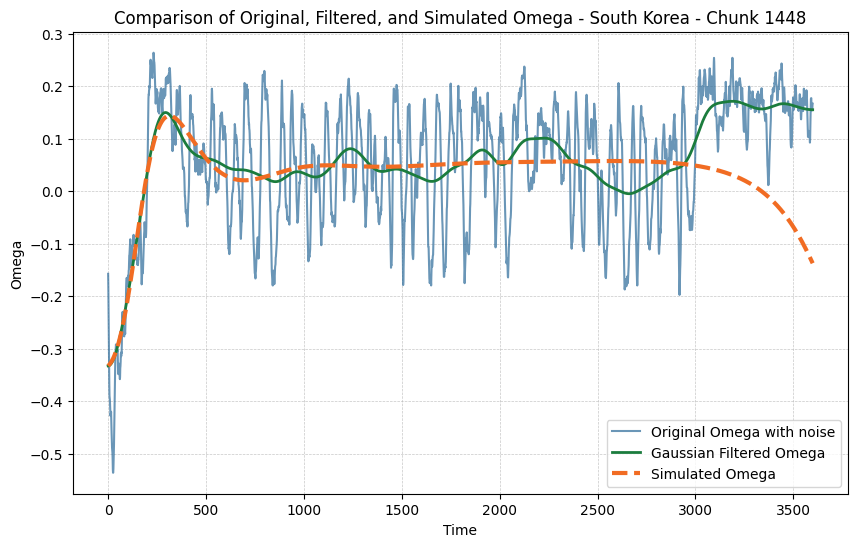

In [42]:
n = 1447
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 17)
simulate_sindy_model(sindy_models['exp_3600'][n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [ ]:
# use the mean coefficients to simulate the model
 

In [24]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    region_colors = {'South Korea': '#1b9e77'}

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "", color=region_colors[region_name])

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Feature Candidates", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for South Korea", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    return ax  # Return the ax object

<Axes: title={'center': 'Coefficients with Error Bars for South Korea'}, xlabel='Feature Candidates', ylabel='Coefficient Value'>

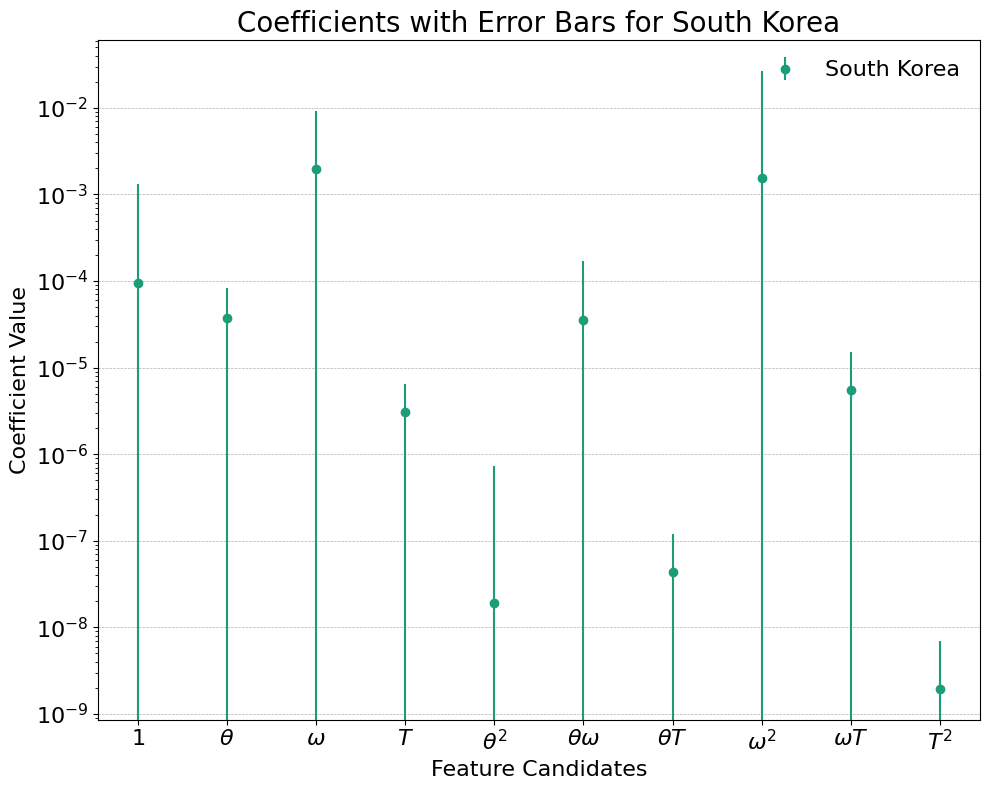

In [26]:
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$T$', 
                r'$\theta^2$', r'$\theta\omega$', r'$\theta T$', r'$\omega^2$', 
                r'$\omega T$',r'$T^2$']
#apply plot_coefficients_for_regions function for South Korea
plot_coefficients_for_regions({'South Korea': {'means': skmean, 'stds': skstd}}, feature_names)